In [1]:
import cv2
import json
import treepoem
import numpy as np
import sympy as sp
from pathlib import Path
from matplotlib import pyplot as plt

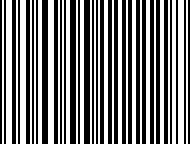

In [2]:
barimg = treepoem.generate_barcode('ean13', '100000011111')
barimg

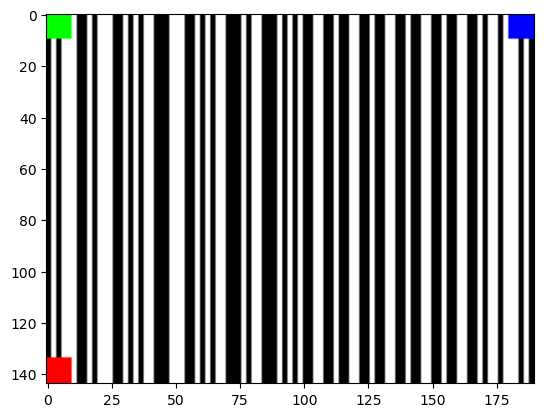

In [3]:
bar = np.array(barimg).copy()
bar[-10:, :10] = [255, 0, 0]
bar[:10, :10] = [0, 255, 0]
bar[:10, -10:] = [0, 0, 255]

plt.imshow(bar)

In [4]:
bar.shape

(144, 190, 3)

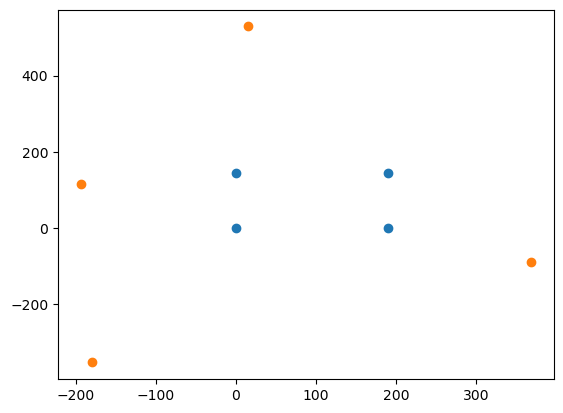

In [181]:
xps = [0, 0, 1, 1]
yps = [1, 0, 0, 1]
height, width, _ = bar.shape
corners = np.array([[x*width, y*height] for x, y in zip(xps, yps)])
corners_old = corners.copy()

dx, dy = np.random.exponential(scale=width, size=corners.shape).T

corners[0,0] -= dx[0]
corners[0,1] += dy[0]

corners[1,0] -= dx[1]
corners[1,1] -= dy[1]

corners[2,0] += dx[2]
corners[2,1] -= dy[2]

corners[3,0] += dx[3]
corners[3,1] += dy[3]

theta = np.math.pi*np.random.random()*2
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

corners = corners@R

M = cv2.getPerspectiveTransform(corners_old.astype(np.float32), corners.astype(np.float32))

plt.scatter(*corners_old.T)
plt.scatter(*corners.T)

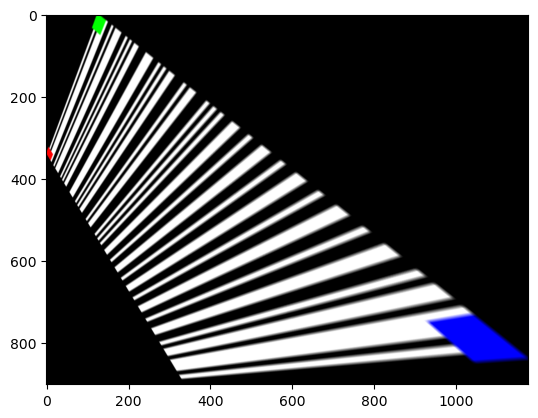

In [182]:
corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
M[:-1,-1] *= 0
M[-1,-1] = 1
coords = (M@corners)[:-1]
M[:-1,-1] = -np.min(coords, axis=-1)
coords = M@corners
coords = coords[:-1]/coords[-1]

new_sz = np.ceil(np.max(coords, axis=-1)).astype(np.int32)

img = cv2.warpPerspective(bar, M, new_sz)
plt.imshow(img)

In [75]:
import cv2
import json
import argparse
import treepoem
import numpy as np
from matplotlib import pyplot as plt


def load_json(fname, *args, **kwargs):
    with open(fname) as f:
        return json.load(f, *args, **kwargs)


def save_json(jd, fname, *args, indent=4, **kwargs):
    with open(fname, 'w') as f:
        json.dump(jd, f, *args, indent=indent, **kwargs)


def aligned_affine(bar, M, fix_position=True):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    
    height, width, _ = bar.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
    
    if fix_position:
        M = M.copy()
        M[:,-1] *= 0
        M[:,-1] = -np.min(M@corners, axis=-1)

    new_sz = np.ceil(np.max(M@corners, axis=-1)).astype(np.int32)
    img = cv2.warpAffine(bar, M, new_sz)
    return img, M@corners


def generate_perspective_distort(img, alpha=0.1, beta=0.01):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    height, width, _ = img.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T

    M = np.zeros((3,3))
    M[:-1,:-1] = np.random.randn(2, 2)*alpha + np.eye(2)*(1.-alpha)
    M[-1, :-1] = beta*np.abs(np.random.randn(1,2))
    M[:-1,-1] *= 0
    M[-1,-1] = 1
    coords = (M@corners)[:-1]
    M[:-1,-1] = -np.min(coords, axis=-1)
    return M


def aligned_perspective(img, M):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    height, width, _ = img.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
    coords = M@corners
    coords = coords[:-1]/coords[-1]
    
    new_sz = np.ceil(np.max(coords, axis=-1)).astype(np.int32)
    
    img = cv2.warpPerspective(img, M, new_sz)
    return img, coords


def coords_to_regions(coords, dimensions):
    res = []
    for i in range(len(coords)):
        ptsx, ptsy = coords[i]
        
        res.append({\
        'shape_attributes': {
            'name': 'polygon',
            'all_points_x': list(ptsx),
            'all_points_y': list(ptsy)
        },
        'region_attributes': {'barcode': dimensions[i]}})
    return res


def export(img, name, coords, dimensions):
    #np.clip(img, 0, 1)
    plt.imsave(f'{name}.jpg', img)
    res = {f'{name}.jpg813086': {'filename': f'../code/{name}.jpg',
    'size': 813086,
    'regions': coords_to_regions(coords, dimensions),
    'file_attributes': {}}}
    save_json(res, f'{name}.json')


def generate_distorted(barcode_types, content_barcodes, source_img=None, distortions=None):
    barimgs = [treepoem.generate_barcode(typ, content) for typ, content in zip(barcode_types, content_barcodes)]
    if distortions is None:
        distortions = [generate_perspective_distort(np.array(img)) for img in barimgs]
    # imgs, coords = zip(*[aligned_affine(np.array(img), dis) for img, dis in zip(barimgs, distortions)])
    imgs, coords = zip(*[aligned_perspective(np.array(img), dis) for img, dis in zip(barimgs, distortions)])
    # masks, _ = zip(*[aligned_affine(np.ones_like(img), dis) for img, dis in zip(barimgs, distortions)])
    masks, _ = zip(*[aligned_perspective(np.ones_like(img), dis) for img, dis in zip(barimgs, distortions)])
    
    if source_img is None:
        width, height, _ = np.max([img.shape for img in imgs], axis=0)*len(imgs)//3
        combined = np.zeros((width, height, 3), dtype=imgs[0].dtype)
    else:
        combined = plt.imread(source_img)[:,:,:3]
        width, height, _ = combined.shape

    for i in range(len(imgs)):
        w, h, _ = imgs[i].shape
        dw = np.random.randint(0, width - w)
        dh = np.random.randint(0, height - h)
        coords[i][0] += dh
        coords[i][1] += dw
        expanded_img = np.zeros_like(combined)
        expanded_img[dw:w+dw, dh:h+dh] = imgs[i]
        expanded_mask = np.zeros_like(combined)
        expanded_mask[dw:w+dw, dh:h+dh] = masks[i]
        combined = combined*(1-expanded_mask) + expanded_img
    return combined, coords

In [ ]:
cv2.perspectiveTransform()